# Assignment 2


#### 1. 复习上课内容以及复现课程代码

在本部分，你需要在复习上课内容和课程代码后，复现课程代码。 

#### 2. 回答以下理论题目

###       < 评阅点 >： 答案是否正确完整

###### 2.1 What conditions are required to make the BFS return the optimal solution ?

无权图；针对边的权值不为负数的图，每次迭代时历史路径中找到当前最短路径，或对历史路径进行排序。

##### 2.2 Is there a way to make DFS find the optimal solution ? (You may need to read some material about iterative DFS)

迭代深化深度优先搜索(IDDFS)，对DFS的搜索深度加以限制，不断放宽搜索深度限制重复进行查找，直到找到目标。首先，可以从深度为0开始，即判断根节点是否为目标节点，如果不是，深度加一。当深度值为k时，查找距离根节点距离为k的所有节点中是否有目标节点，若有，直接返回，若没有，k=k+1，继续查找。本质上等价于BFS，但占用内存更少。

##### 2.3 In what conditions BFS is a better choice than DFS and vice versa ?

BFS：无权图或权值不为负数的图的最短路径等；
DFS：图的遍历，检测连通性，单点路径等。

##### 2.4 When can we use machine learning ?

存在一种模型，无法通过数学公式准确计算这一模型，拥有大量数据。

##### 2.5 What is the gradient of a function ?

梯度是一个向量，表示函数在该点处的方向导数沿着该方向取得最大值，即函数在该点处沿着该方向变化最快，向量的模就是函数的变化率。

##### 2.6 How can we find the maximum value of a function using the information of gradient ?

函数在某点处沿着该点梯度的方向变化最快，根据该点处的导数值判断函数值沿着梯度方向增大或减小。
若导数值为正，则函数值沿着梯度方向增大，向该方向递增直至导数值为0，此时取得函数极大值。
若导数值为负，则函数值沿着梯度方向减小，向反方向递增直至导数值为0，此时取得函数极大值。

#### 3. 实践部分  寻找地铁路线

### < 评阅点 >  1: 爬虫爬取数据是否完整;  2:搜索算法是否正确

In this part, although we recommend you to use Beijing subway, you still can use the subway map of any cities that you are interested in. 

Please using the search policy to implement an agent. This agent receives two input, one is @param start station and the other is @param destination. Your agent should give the optimal route based on Beijing Subway system.

Deadline: 2019-October-27

#### Procedures

#### 1. Get data from web.  

Some tips: 

a. You might need this package: requests[https://2.python-requests.org/en/master/] to get webpages

b.You might need to use Regular Expression and Beautiful Soap package to parse the webpages

In [1]:
import requests
import urllib3
import re
from bs4 import BeautifulSoup as bs
from collections import defaultdict
import json

In [2]:
#获取北京地铁路线图，与实际站点位置有出入
urllib3.disable_warnings()
# https://map.bjsubway.com/subwaymap/interchange.xml
r = requests.get('https://map.bjsubway.com/subwaymap/beijing.xml?v=2',verify=False)
r.encoding = r.apparent_encoding

In [3]:
#获取北京地铁实际经纬度
r_real = requests.get('http://map.amap.com/service/subway?_1571808376994&srhdata=1100_drw_beijing.json',verify=False)
r_real_text = json.loads(r_real.text)

In [4]:
#通过正则表达式解析数据（北京地铁路线图）
def general_subway_by_re(text):
    subway = {}
    
    all_text = re.split('<l',text)
    for t in all_text:
        stub = re.findall('lid="(\w+\(?\w?\)?)"',t)
        if len(stub) == 0:
            continue
        stub = stub[0]
        stat = re.findall('lb="(\w+)".* x=" ?(-?\d+) ?".* y=" ?(-?\d+) ?".* iu="(\w+)"',t)
        subway[stub] = []
        for i in range(len(stat)):
            if stat[i][3] == 'true':
                subway[stub].append(stat[i])
    
        loop = re.findall('loop="(\w+)"',t)[0]
        if loop == 'true':
            subway[stub].append(subway[stub][0])
        elif subway[stub][0] == subway[stub][-1]:
            subway[stub].append(False)
    return subway

In [5]:
re.findall('lb="(\w+)" x="(-?\d+)" y="(\d+)"','<p n="0" acc="151018517" lb="燕山" x="-20" y="1131" ds="0" ud="2.606" dd="0"/>')

[('燕山', '-20', '1131')]

In [6]:
re.findall('lb="(\w+)".* x="(-?\d+)".* y="(-?\d+)"','p n="0" acc="151019777" lb="四惠" x="1334" dy="-4.6" y="799" dox="0" doy="-1"')

[('四惠', '1334', '799')]

In [7]:
re.findall('lb="(\w+)".* x=" ?(-?\d+) ?".* y=" ?(-?\d+) ?"','p n="0" acc="151019049" lb="西二旗" x="757 " y="423" uox="1"')

[('西二旗', '757', '423')]

In [8]:
#通过BeautifulSoup解析数据（北京地铁路线图）
def general_subway_by_bs(text):
    bs_text = bs(text, 'xml')
    subway = defaultdict(list)
        
    all_text = bs_text.find_all('l')
    for t in all_text:
        lid = t['lid']
        loop = t['loop']
        p = t.find_all('p')
        for bp in p:
            try:
                lb = bp['lb']
                if lb == '' or bp['iu'] == 'false':
                    continue
                x = bp['x']
                y = bp['y']
                subway[lid].append([lb, x, y])
            except KeyError as e:
                continue
        if loop == 'true':
            subway[lid].append(subway[lid][0])
        elif subway[lid][0] == subway[lid][-1]:
            subway[lid].append(False)
    return subway

In [9]:
# json解析（北京地铁实际位置图）
def general_subway_by_real_text(text):
    subway = defaultdict(list)
        
    all_text = text['l']
    for t in all_text:
        ln = t['kn']
        lo = t['lo']
        st = t['st']
        for s in st:
            n = s['n']
            x_y = re.split(',', s['sl'])
            x = x_y[0]
            y = x_y[1]
            subway[ln].append([n, x, y])
        if lo == '1':
            subway[ln].append(subway[ln][0])
    return subway

##### 2. Preprocessing data

Some tips:

a. Find a suitable way to save the data you get from the web. (Note: The way you use to save the data should be able to be used to create the graph that your agent is going to explore)

In [10]:
def general_detail_info(subway):
    station = {}
    routes = defaultdict(list)
    for k in subway.keys():
        v = subway.get(k)
        new_v = set()
        back = True
        if v[-1] == False:
            v.pop()
            back = False
            new_v = []
        v_len = len(v)
        for i in range(v_len):
            if i < v_len - 1:
                routes[v[i][0]].append(v[i + 1][0])
                if v[i][0] not in routes[v[i + 1][0]] and back:
                    routes[v[i + 1][0]].append(v[i][0])
            station[v[i][0]] = [float(v[i][1]), float(v[i][2])]
            v[i] = v[i][0]
            if back:
                new_v.add(v[i])
            else:
                new_v.append(v[i])
        subway[k] = new_v
    return station, routes

In [11]:
#subway = general_subway_by_re(r.text)
subway = general_subway_by_bs(r.text)
station, routes = general_detail_info(subway)

In [12]:
import networkx as nw
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

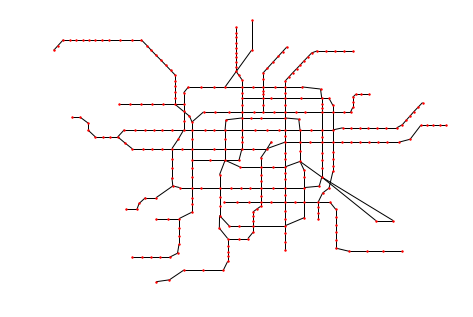

In [14]:
station_graph = nw.Graph(routes)
nw.draw(station_graph, station, with_labels=False, node_size=2)

In [15]:
#北京地铁路线图与实际位置有差别，但北京地铁实际位置图地铁路线不够确定
#比如首都机场线，东直门—>三元桥—>T3航站楼—>T2航站楼—>三元桥—>东直门
#打算沿用北京地铁路线图的路线关系

real_subway = general_subway_by_real_text(r_real_text)
for v in real_subway.values():
    for info in v:
        if station.get(info[0]) is None:
            if info[0] == 'T3航站楼':
                station['3号航站楼'] = [float(info[1]), float(info[2])]
            if info[0] == 'T2航站楼':
                station['2号航站楼'] = [float(info[1]), float(info[2])]
        else:
            station[info[0]] = [float(info[1]), float(info[2])]

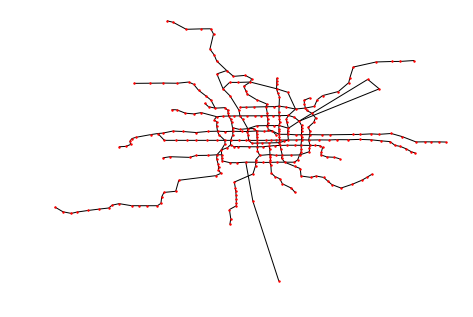

In [16]:
station_graph = nw.Graph(routes)
nw.draw(station_graph, station, with_labels=False, node_size=2)

#### 3. Build the search agent

Build the search agent based ont he graph you built.

for example, if you use Beijing subway graoh, and you run:

\>>> search("奥体中心“，”天安门“）

You should get the result as follows: 奥体中心 -> A ->B ->C ... -> 天安门

In [17]:
def search(p_name1, p_name2):
    if p_name1 == p_name2:
        return [p_name1]
    if station.get(p_name1) is None or station.get(p_name2) is None:
        return
    paths = [[p_name1]]
    visited = set(p_name1)
    while paths:
        p = paths.pop(0)
        #p = paths.pop()
        successor = routes[p[-1]]
        for s in successor:
            if s in visited:
                continue
            path = p + [s]
            #paths = [path] + paths
            paths.append(path)
            if s == p_name2:
                return path
            visited.add(s)

In [18]:
search("奥体中心","天安门")

In [19]:
search("奥体","天安门西")

In [20]:
search("奥体中心","天安门西")

['奥体中心',
 '北土城',
 '安华桥',
 '安德里北街',
 '鼓楼大街',
 '积水潭',
 '西直门',
 '车公庄',
 '阜成门',
 '复兴门',
 '西单',
 '天安门西']

In [21]:
search("土桥","天安门西")

['土桥',
 '临河里',
 '梨园',
 '九棵树',
 '果园',
 '通州北苑',
 '八里桥',
 '管庄',
 '双桥',
 '传媒大学',
 '高碑店',
 '四惠东',
 '四惠',
 '大望路',
 '国贸',
 '永安里',
 '建国门',
 '东单',
 '王府井',
 '天安门东',
 '天安门西']

### (Optional) Improve your agent to make it able to find a path based on different strategies

###  <评阅点> : 是否正确得到不同目标下的路径。

Some ideas you might want to try:

a. Find the shortest path between two stations.

In [22]:
import math
def distance(p1, p2):
    #return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)
    return geo_distance(p1, p2)

def findMinIndex(l):
    min_value = None
    min_index = 0
    l_len = len(l)
    for i in range(l_len):
        if min_value is None or l[i] < min_value:
            min_value = l[i]
            min_index = i
    return min_index

def swap(l, i, j):
    v = l[i]
    l[i] = l[j]
    l[j] = v
    
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [23]:
def findShortestPath(p_name1, p_name2):
    if station.get(p_name1) is None or station.get(p_name2) is None:
        return
    paths = [[p_name1]]
    values = [0]
    sum_value = [distance(station[p_name1], station[p_name2])]
    
    visited = {p_name1: 0}
    while paths:
        #min_index = findMinIndex(values)
        min_index = findMinIndex(sum_value)
        swap(sum_value, -1, min_index)
        swap(values, -1, min_index)
        swap(paths, -1, min_index)
        
        if paths[-1][-1] == p_name2:
            return paths[-1]
        
        p = paths.pop()
        v = values.pop()
        sum_value.pop()
        successor = routes[p[-1]]
        for s in successor:
            new_v = v + distance(station[p[-1]], station[s])
            new_sum_v = new_v + distance(station[s], station[p_name2])
            
            if visited.get(s) is None or new_sum_v < visited[s]:
                visited[s] = new_sum_v
            else:
                continue
                
            path = p + [s]
            paths.append(path)
            
            values.append(new_v)
            sum_value.append(new_sum_v)

In [24]:
findShortestPath("奥体中心","天安门西")

['奥体中心',
 '北土城',
 '安华桥',
 '安德里北街',
 '鼓楼大街',
 '什刹海',
 '南锣鼓巷',
 '东四',
 '灯市口',
 '东单',
 '王府井',
 '天安门东',
 '天安门西']

In [25]:
findShortestPath("奥体中心","天安门")

In [26]:
findShortestPath("奥体中心","燕山")

['奥体中心',
 '北土城',
 '安华桥',
 '安德里北街',
 '鼓楼大街',
 '积水潭',
 '西直门',
 '车公庄',
 '车公庄西',
 '白石桥南',
 '白堆子',
 '军事博物馆',
 '北京西站',
 '六里桥东',
 '六里桥',
 '七里庄',
 '丰台东大街',
 '丰台南路',
 '科怡路',
 '丰台科技园',
 '郭公庄',
 '大葆台',
 '稻田',
 '长阳',
 '篱笆房',
 '广阳城',
 '良乡大学城北',
 '良乡大学城',
 '良乡大学城西',
 '良乡南关',
 '苏庄',
 '阎村东',
 '紫草坞',
 '阎村',
 '星城',
 '大石河东',
 '马各庄',
 '饶乐府',
 '房山城关',
 '燕山']

b. Find the path that requires minimum transfers between two stations.

In [27]:
def sameRouteJudge(last_p, now_p, next_p):
    for v in subway.values():
        if type(v) == set:
            if last_p in v and now_p in v and next_p in v:
                return 0
        elif type(v) == list:
            i = 1
            while i + 1 < len(v):
                if v[i] == now_p and v[i - 1] == last_p and v[i + 1] == next_p:
                    return 0
                i += 1
    return 1

In [28]:
def findMinTransfers(p_name1, p_name2):
    if station.get(p_name1) is None or station.get(p_name2) is None:
        return
    paths = [[p_name1]]
    values = [0]
    
    visited = {p_name1: 0}
    while paths:
        min_index = findMinIndex(values)
        swap(values, -1, min_index)
        swap(paths, -1, min_index)
        
        p = paths.pop()
        v = values.pop()
        
        if p[-1] == p_name2:
            return p
        
        successor = routes[p[-1]]
        for s in successor:
            if s in p:
                continue
            r = v
            if len(p) > 1:
                r += sameRouteJudge(p[-2], p[-1], s)
            if visited.get(s) is None or r <= visited[s]:
                visited[s] = r
            else:
                continue
            path = p + [s]
            paths.append(path)
            values.append(r)

In [29]:
findMinTransfers("柳芳","亮马桥")

['柳芳', '光熙门', '芍药居', '太阳宫', '三元桥', '亮马桥']

In [30]:
findMinTransfers("奥体中心","天安门西")

['奥体中心',
 '北土城',
 '安华桥',
 '安德里北街',
 '鼓楼大街',
 '安定门',
 '雍和宫',
 '东直门',
 '东四十条',
 '朝阳门',
 '建国门',
 '北京站',
 '崇文门',
 '前门',
 '和平门',
 '宣武门',
 '长椿街',
 '复兴门',
 '西单',
 '天安门西']

In [31]:
findMinTransfers("2号航站楼","3号航站楼")

['2号航站楼', '三元桥', '3号航站楼']

In [32]:
findMinTransfers("3号航站楼","2号航站楼")

['3号航站楼', '2号航站楼']

In [33]:
findMinTransfers("奥体中心","天安门")

In [34]:
findMinTransfers("东直门","太阳宫")

['东直门', '三元桥', '太阳宫']

In [35]:
findMinTransfers("奥体中心","燕山")

['奥体中心',
 '北土城',
 '健德门',
 '牡丹园',
 '西土城',
 '知春路',
 '知春里',
 '海淀黄庄',
 '苏州街',
 '巴沟',
 '火器营',
 '长春桥',
 '车道沟',
 '慈寿寺',
 '西钓鱼台',
 '公主坟',
 '莲花桥',
 '六里桥',
 '七里庄',
 '丰台东大街',
 '丰台南路',
 '科怡路',
 '丰台科技园',
 '郭公庄',
 '大葆台',
 '稻田',
 '长阳',
 '篱笆房',
 '广阳城',
 '良乡大学城北',
 '良乡大学城',
 '良乡大学城西',
 '良乡南关',
 '苏庄',
 '阎村东',
 '紫草坞',
 '阎村',
 '星城',
 '大石河东',
 '马各庄',
 '饶乐府',
 '房山城关',
 '燕山']

c. Combine the previous two ideas, find a more suitable path.

In [36]:
def findMinIndex(l):
    min_value = None
    min_index = 0
    l_len = len(l)
    for i in range(l_len):
        if min_value is None or l[i] < min_value:
            min_value = l[i]
            min_index = i
    return min_index

def findMinTransfersAndShortestPath(p_name1, p_name2):
    if station.get(p_name1) is None or station.get(p_name2) is None:
        return
    paths = [[p_name1]]
    values = [[0, 0]]
    
    min_p = None
    min_v = [0, 0]
    
    visited = {p_name1: 0}
    while paths:
        min_value = None
        min_index = 0
        l_len = len(values)
        for i in range(l_len):
            if min_value is None or values[i][0] < min_value[0] or (values[i][0] == min_value[0] and values[i][1] < min_value[1]):
                min_value = values[i]
                min_index = i
        
        swap(values, -1, min_index)
        swap(paths, -1, min_index)
        
        p = paths.pop()
        v = values.pop()
        
        if p[-1] == p_name2:
            if min_p is None or min_v[0] > v[0] or (min_v[0] == v[0] and min_v[1] > v[1]):
                min_p = p
                min_v = v
                continue
        
        successor = routes[p[-1]]
        for s in successor:
            if s in p:
                continue
            r = v[0]
            if len(p) > 1:
                r += sameRouteJudge(p[-2], p[-1], s)
            if visited.get(s) is None or r <= visited[s]:
                visited[s] = r
            else:
                continue
            
            path = p + [s]
            paths.append(path)
            values.append([r, v[1] + distance(station[p[-1]], station[s])])
    return min_p

In [37]:
findMinTransfersAndShortestPath("奥体中心","天安门西")

['奥体中心',
 '北土城',
 '安华桥',
 '安德里北街',
 '鼓楼大街',
 '积水潭',
 '西直门',
 '车公庄',
 '阜成门',
 '复兴门',
 '西单',
 '天安门西']

In [38]:
findMinTransfersAndShortestPath("柳芳","亮马桥")

['柳芳', '光熙门', '芍药居', '太阳宫', '三元桥', '亮马桥']

In [39]:
findMinTransfersAndShortestPath("3号航站楼","2号航站楼")

['3号航站楼', '2号航站楼']

In [40]:
findMinTransfersAndShortestPath("2号航站楼","3号航站楼")

['2号航站楼', '三元桥', '3号航站楼']

In [41]:
findMinTransfersAndShortestPath("回龙观","石榴庄")

['回龙观',
 '霍营',
 '立水桥',
 '北苑',
 '望京西',
 '芍药居',
 '太阳宫',
 '三元桥',
 '亮马桥',
 '农业展览馆',
 '团结湖',
 '呼家楼',
 '金台夕照',
 '国贸',
 '双井',
 '劲松',
 '潘家园',
 '十里河',
 '分钟寺',
 '成寿寺',
 '宋家庄',
 '石榴庄']

In [42]:
findMinTransfersAndShortestPath("圆明园","将台")

['圆明园',
 '北京大学东门',
 '中关村',
 '海淀黄庄',
 '人民大学',
 '魏公村',
 '国家图书馆',
 '动物园',
 '西直门',
 '新街口',
 '平安里',
 '西四',
 '灵境胡同',
 '西单',
 '宣武门',
 '菜市口',
 '陶然亭',
 '北京南站',
 '永定门外',
 '景泰',
 '蒲黄榆',
 '方庄',
 '十里河',
 '北工大西门',
 '平乐园',
 '九龙山',
 '大望路',
 '金台路',
 '朝阳公园',
 '枣营',
 '东风北桥',
 '将台']

Compare your results with results obtained by using some apps such as Baidu map, A map, Google map or Apple map. If there is difference, try to explanate it.

使用百度地图查看，考虑到起始结束时间，路费，其它出行方式等因素，部分结果不同。例如，“3号航站楼”到“2号航站楼”虽只有1站不用换乘，但由于票价过高，不在推荐之列。而“2号航站楼”到“3号航站楼”没有直达地铁，绕路距离太长，故也不在推荐方式之中。另外，百度地图避免了绕远路的情况，例如，“圆明园”到“将台”，我的路线仅包括一次换乘，百度地图首推的路线却有两次但是距离更短。不过考虑到换乘过程中等待时间，最佳路线还是得由用户自定。

## Congratulations ! You have finished the assignment of week 2.

### If you have any suggestions regarding the teaching, please feel free to send them to my eamil (eric.lee.xiao@gmail.com) 